# Identifying Questions Pairs

We will train a model to predict whether a pair of questions/queries are similar or dissimilar.

Dataset Used: [Quora Question Pairs](https://quoradata.quora.com/First-Quora-Dataset-Release-Question-Pairs)

## Import Libraries

In [ ]:
!pip install -q trax

import os
import re
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Dataset

In [105]:
df = pd.read_csv('./question-pairs-dataset/questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [106]:
print('Length of data:', len(df))

Length of data: 404351


In [107]:
# Drop the id colunms
df.drop(columns=['id', 'qid1', 'qid2'], inplace=True)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## EDA

### Check Summary Statistics of Dataset

In [108]:
df.describe(include='all')

,question1,question2,is_duplicate
count,404350,404349,404351.000000
unique,290472,299202,NaN
top,How do I improve my English speaking?,How can you look at someone's private Instagra...,NaN
freq,50,120,NaN
mean,NaN,NaN,0.369248
std,NaN,NaN,0.482602
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


### Identify and treat "NaN" values in dataset

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404350 non-null  object
 1   question2     404349 non-null  object
 2   is_duplicate  404351 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


We see presence of `'NaN'` values which needs to be taken care of. We confirm this by running below  command.

In [110]:
df_null = pd.DataFrame(df.isnull().any().values, 
                       index=df.isnull().any().index, 
                       columns=['contains_null'])
df_null

,contains_null
question1,True
question2,True
is_duplicate,False


In [111]:
# Check the no. of missing values in the data.
df.isnull().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [112]:
# Get the records containing the null values.
df_null = df[df.isnull().any(axis=1)]
df_null

,question1,question2,is_duplicate
105796,How can I develop android app?,NaN,0
201871,How can I create an Android app?,NaN,0
363416,NaN,My Chinese name is Haichao Yu. What English na...,0


In [113]:
# Delete the records containg the null values.
df.drop(index=df_null.index, inplace=True)

# Validate presence of null values.
df_null = pd.DataFrame(df.isnull().any().values, 
                       index=df.isnull().any().index, 
                       columns=['Contains_null'])
df_null

,Contains_null
question1,False
question2,False
is_duplicate,False


All records containing null values have been removed. We can now proceed to next step.

In [114]:
# Split the data into train and test dataset.
N_train = 300000
df_train = df[:N_train]
df_test = df[N_train:]
print('Length of training set: ', len(df_train))
print('Length of test set: ', len(df_test))

Length of training set:  300000
Length of test set:  104348


In [115]:
# Extract the index of duplicate questions.
td_index = df_train[df_train['is_duplicate'] == 1].index  

print('number of duplicate questions: ', len(td_index))
print('number of non-duplicate question: ', len(df_train) - len(td_index))
print(f'balance ration: {len(td_index) / (len(df_train) - len(td_index)):.2f}')
print('indexes of first ten duplicate questions:', td_index[:10])

number of duplicate questions:  111487
number of non-duplicate question:  188513
balance ration: 0.59
indexes of first ten duplicate questions: Int64Index([5, 7, 11, 12, 13, 15, 16, 18, 20, 29], dtype='int64')


In [116]:
print(df_train['question1'][5])  #  Example of question duplicates (first one in data)
print(df_train['question2'][5])
print('is_duplicate: ', df_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


### Distribution of the length of sequences in Train Dataset.

We check the distribution of the length of the questions/sentences in our 'question1' and 'question2' train dataset which are duplicates.

This gives an idea of using optimal `max_len` when forming tensors so that minimal padding is used during training.

In [117]:
df_Q1_len = df_train['question1'][td_index].apply(lambda sentence: len(nltk.word_tokenize(sentence))) 
df_Q2_len = df_train['question2'][td_index].apply(lambda sentence: len(nltk.word_tokenize(sentence))) 

In [118]:
df_Q1_len.groupby(df_Q1_len).sum()

question1
1          1
3         15
4       1904
5      11110
6      33654
7      69979
8     112032
9     138771
10    141910
11    126698
12     99000
13     79300
14     64680
15     58410
16     51264
17     41786
18     34002
19     25859
20     22520
21     22890
22     15202
23     16422
24     15600
25      9750
26      7150
27      6804
28      6524
29      4785
30      5520
31      3007
32      3200
33      2706
34      1700
35      1155
36      1152
37      1036
38       418
39       624
40       280
41       410
42        84
43        86
44       308
45        90
46       138
47        47
48        48
49        49
50        50
51       102
52       104
53       159
57        57
58       116
60        60
61        61
81        81
Name: question1, dtype: int64

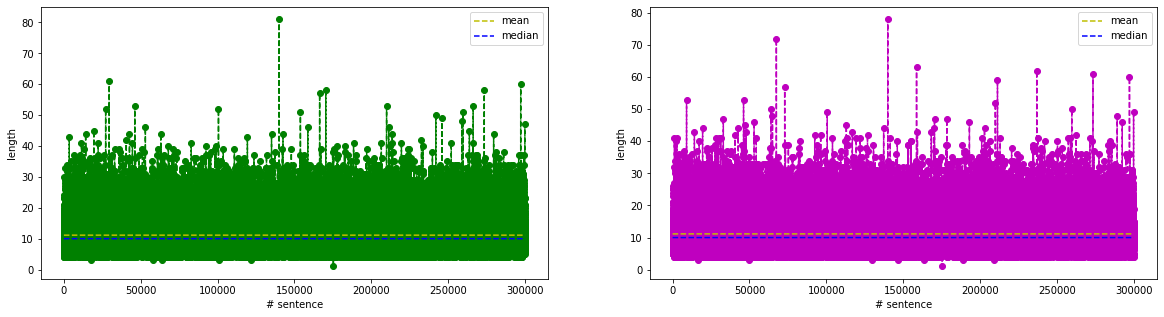

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) 

# Reset index.
df_Q1_len.reset_index()
df_Q2_len.reset_index()

# Compute mean of data points for both Q1 and Q2 dataset.
mean_Q1 = [np.mean(df_Q1_len)] * len(df_Q1_len) 
mean_Q2 = [np.mean(df_Q2_len)] * len(df_Q2_len) 

# Compute median of datapoints.
median_Q1 = [np.median(df_Q1_len)] * len(df_Q1_len) 
median_Q2 = [np.median(df_Q2_len)] * len(df_Q2_len) 

# Plot length of sentence data points.
axes[0].plot(df_Q1_len.index, df_Q1_len, 'g--o')
axes[1].plot(df_Q2_len.index, df_Q2_len, 'm--o')

# Plot the mean of the data points.
axes[0].plot(df_Q1_len.index, mean_Q1, 'y--', label='mean')
axes[1].plot(df_Q2_len.index, mean_Q2, 'y--', label='mean')

# Plot the median of the data points.
axes[0].plot(df_Q1_len.index, median_Q1, 'b--', label='median')
axes[1].plot(df_Q2_len.index, median_Q2, 'b--', label='median')

# Label the plots.
for ax in axes:
    ax.set_ylabel('length')
    ax.set_xlabel('# sentence')
    ax.legend()
fig.show()

From our analysis we can choose range of `max_len` $\sim (11, 21 )$ 

## Create Input Tensors for training
### Store the 'questions' column to numpy arrays

In [120]:
Q1_train_words = np.array(df_train['question1'][td_index])
Q2_train_words = np.array(df_train['question2'][td_index])

Q1_test_words = np.array(df_test['question1'])
Q2_test_words = np.array(df_test['question2'])
y_test  = np.array(df_test['is_duplicate'])

In [121]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train_words[0])
print('Question 2: ', Q2_train_words[0], '\n')
print('Question 1: ', Q1_train_words[5])
print('Question 2: ', Q2_train_words[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test_words[0])
print('Question 2: ', Q2_test_words[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I become Mutual funds distributer for all company mutual funds?
Question 2:  How do I become mutual funds distributor for all company mutual funds? 

is_duplicate = 1 



In [122]:
# Initialize Tensor arrays to store numbers mapped to words.
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

### Build the vocabulary

In [123]:
from collections import defaultdict


vocab = defaultdict(lambda: 0)  # Encodes all OOV words to 0.
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    # Tokenize the sentences from the train set.
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  36269


In [124]:
print('Some elements in the vocabulary:\n' ,list(vocab.items())[:7])

Some elements in the vocabulary:
 [('<PAD>', 1), ('Astrology', 2), (':', 3), ('I', 4), ('am', 5), ('a', 6), ('Capricorn', 7)]


In [125]:
for idx in range(len(Q1_test_words)):
    # Tokenize the sentences from the test set.
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

### Convert Questions to Tensors

In [126]:
# Encode the sentences from the train and test set using the word to 
# indices mapping (the vocabulary dictionary)

for idx in range(len(Q1_train)):
    Q1_train[idx] = [vocab[word] for word in Q1_train[idx]]
    Q2_train[idx] = [vocab[word] for word in Q2_train[idx]]

for idx in range(len(Q1_test)):
    Q1_test[idx] = [vocab[word] for word in Q1_test[idx]]
    Q2_test[idx] = [vocab[word] for word in Q2_test[idx]]

In [127]:
# Check out the Tensors.
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

first question in the test set:

How do I become Mutual funds distributer for all company mutual funds? 

encoded version:
[32, 38, 4, 521, 1340, 735, 0, 65, 47, 1476, 1341, 735, 21]


### Create Validation Set

We split the train set into a training and validation set to train and evaluate our model.

In [128]:
cut_off = int(len(Q1_train)*.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111487
The length of the training set is:   89189
The length of the validation set is:  22298


### Create Data Generator

We create an infinite data generator that will takes in $Q1\ (train\_Q1)$  and $Q2\ (train\_Q2)$ and return a tuple of two arrays, each having a batch of size `batch_size` in the following format:

$([q1_1, q1_2, q1_3, ...],[q2_1, q2_2,q2_3, ...])$, where $q1_i$ and $q2_i$ are duplicate if and only if $i = k$ and not duplicate if $i \neq k$

Note that once all training data is exhausted the data generator will loop over and start from beginning to maintain infinite supply of data.


In [129]:
def data_generator(train_Q1,       
                   train_Q2,
                   batch_size, 
                   pad,
                   max_len=16,  # We choose this value from our analysis.
                   shuffle=True):
    idx = 0
    idx_list = list(range(len(train_Q1)))
    
    if shuffle:
        np.random.shuffle(idx_list)
    
    batch_Q1, batch_Q2 = [], []
    while True: 
        if idx >= len(idx_list):
            idx = 0
            if shuffle: 
                np.random.shuffle(idx_list)
                
        # If length of sentence is less than specified max_len, add padding. 
        if len(train_Q1[idx_list[idx]]) - max_len < 0:   
            pad_len = max_len - len(train_Q1[idx_list[idx]])
            pad_train_Q1_sample = train_Q1[idx_list[idx]] + [pad] * pad_len
        # If length of sentence is more than specified max_len, clip the sentence to max_len.
        else:
            pad_train_Q1_sample = train_Q1[idx_list[idx]][:max_len]
        
        # Add the sample question to the batch array.
        batch_Q1.append(pad_train_Q1_sample)

        # Do the same for Question2 train data.
        if len(train_Q2[idx_list[idx]]) - max_len < 0:
            pad_len = max_len - len(train_Q2[idx_list[idx]])
            pad_train_Q2_sample = train_Q2[idx_list[idx]] + [pad] * pad_len
        else:
            pad_train_Q2_sample = train_Q2[idx_list[idx]][:max_len]

        batch_Q2.append(pad_train_Q2_sample)
        idx += 1
        
        if len(batch_Q1) == batch_size:
            yield (np.array(batch_Q1), np.array(batch_Q2))
            batch_Q1, batch_Q2 = [], []   

In [130]:
gen = data_generator(train_Q1,
                     train_Q2,
                     batch_size=2, 
                     pad=vocab['<PAD>'],
                     shuffle=True)

In [131]:
next(gen)

(array([[   30,   156,    78,   216,   208,   214,    65,     6,   996,
            21,     1,     1,     1,     1,     1,     1],
        [  520,    97,   797,  4905,   120,  2520, 13257,  7982,    21,
             1,     1,     1,     1,     1,     1,     1]]),
 array([[   30,   156,    78,   216,   208,   214,    39,    52,    24,
            28,    56,   602,    29,    21,     1,     1],
        [  356,    78,  2520, 13257,  7982,   302,    21,     1,     1,
             1,     1,     1,     1,     1,     1,     1]]))

## Defining the Model

We will define a `Siamese` Neural Network.

A Siamese network is a neural network which uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.The Siamese network we will implement looks like this:

<img src = "media/siamese_nn_architecture.png" style="width:600px;"/>

We get the question embedding, run it through an LSTM layer, normalize $v_1$ and $v_2$, and finally use a triplet loss to get the corresponding cosine similarity for each pair of questions.

The triplet loss makes use of a baseline (anchor) input that is compared to a positive input and a negative input. The distance from the baseline (anchor) input to the positive input is minimized, and the distance from the baseline (anchor) input to the negative input is maximized. Essentialy we are trying to maximize the following,

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right)$$
- $A$ is the anchor input, for example $q1_1$, 
- $P$ the duplicate input, for example, $q2_1$, and 
- $N$ the negative input (the non duplicate question), for example $q2_2$.<br>
- $\alpha$ is a margin; indicating by how much we want to push the duplicates from the non duplicates. 
<br>

### Set the Vocab Size and Embedding Dimension for use.

In [132]:
vocab_size=len(vocab)
emb_dim=128

In [133]:
def siamese_model(vocab_size=vocab_size, emb_dim=emb_dim):
    
    def normalize(x):
        return x / fastnp.sqrt(fastnp.sum(x*x,axis=1, keepdims=True))

    model = tl.Serial(
        tl.Embedding(vocab_size=vocab_size, d_feature=emb_dim),
        tl.LSTM(n_units=emb_dim),  # n_units must match emb_dim as per trax documentation.
        # Take the average of each sentence so as to output a tensor having 
        # dimension (batch, emb_dim) instead of (batch, sentence_len, emb_dim).
        tl.Mean(axis=1),  
        tl.Fn('Normalize', lambda x: normalize(x)) # Returns tensor of shape (batch, emb_dim).
    )
    siamese_model_ = tl.Parallel(model, model)
    return siamese_model_

In [134]:
# Validate the model architecture.
model_test = siamese_model()
print(model_test)

Parallel_in2_out2[
  Serial[
    Embedding_77096_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_77096_128
    LSTM_128
    Mean
    Normalize
  ]
]


### Test the model.

In [135]:
# Create dummy inputs of dimension (batch, sentence length) to feed the model.
x1 = np.random.randint(1,4,(2,3))
x2 = np.random.randint(1,4,(2,3))
print('x1: ')
print(x1)
print('x2: ')
print(x2)

x1: 
[[2 2 1]
 [2 1 3]]
x2: 
[[1 3 1]
 [1 3 1]]


### Create dummy model to test.

**NOTE: Initialize the weights. This is essential as the model has trainable weights (due to embedding and other layers) and requires intialized weights to work with.**

In [136]:
model_test = siamese_model(emb_dim=5)
# Initialize the weights. This is essential as the model has 
# trainable weights (due to the embedding and other layers) and requires intialized weights to work with.
model_test.init((trax.shapes.signature(x1),trax.shapes.signature(x2)))
model_test((x1,x2))  # We get output as (batch, emb_dim)

(DeviceArray([[0.46903077, 0.3885538 , 0.4406079 , 0.4772787 , 0.45508873],
              [0.46341446, 0.41889456, 0.4299796 , 0.4807972 , 0.44014326]],            dtype=float32),
 DeviceArray([[0.4446973 , 0.43294337, 0.47258723, 0.43844306, 0.4463556 ],
              [0.4446973 , 0.43294337, 0.47258723, 0.43844306, 0.4463556 ]],            dtype=float32))

## Hard Negative Mining

We will now implement the `TripletLoss`.
The triplet loss in its vanilla form is given by,

\begin{align}
 \mathcal{Loss(A,P,N)} &=\max \left( -cos(A,P)  + cos(A,N) +\alpha, 0\right) \\
\end{align}

To achive better training, a variation of the loss is used. This loss is composed of two terms. One term utilizes the mean of all the non duplicates, the second utilizes the closest negative and is given by,

\begin{align}
 \mathcal{Loss_1(A,P,N)} &=\max \left( -cos(A,P)  + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_2(A,P,N)} &=\max \left( -cos(A,P)  + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\
\end{align}


### Define the Triplet Loss

In [137]:
def TripletLossFn(x1, x2, alpha=0.35):
    
    # Create the cosine similarity matrix for the inputs, i.e. the cos() function.
    # Only dot product is required as the inputs are already normalized.
    cosine_similarity = fastnp.dot(x1, x2.T)  # tensor having dimension (batch_size, batch_size)
    # print('cosine_similarity:\n',cosine_similarity)
    
    # Calculate batch size.
    batch_size = len(cosine_similarity)
    
    # Calculate the cos(A,P) for the inputs.
    cos_ap = fastnp.diag(cosine_similarity).reshape(batch_size, 1)  # tensor having dimension (batch_size, 1)
    
    # Calculate the cos(A,N) for the inputs.
    cos_np = cosine_similarity - fastnp.diag(fastnp.diag(cosine_similarity))  # tensor having dimension (batch_size, batch_size)
    
    # Calculate mean_neg for the inputs.
    mean_neg = fastnp.sum(cos_np, axis=1, keepdims=True) / (batch_size - 1)  # tensor having dimension (batch_size, 1)
    
    # Calculate the closest_neg for the inputs.
    # mask1 = cosine_similarity == cos_ap  # select the principal diagonal elements.

    # selects elements greater than the positive element for each row.
    # mask2 = cos_np > fastnp.diag(cosine_similarity).reshape(batch_size, 1) 
    
    # combine the masks by using logical OR.
    # mask = np.array(mask1) | np.array(mask2)
    # mask = np.array(mask1) 
    
    # cosine_similarity_masked = np.array(cosine_similarity)  # Create a copy.
    
    # Change the value of the selected elements to a number lower than -1. Any value lower than -1 will do.
    # This has the effect of chosing max cos(A,N) for each row.
    # cosine_similarity_masked[mask] = -2
    # print('cosine_similarity_masked:\n', cosine_similarity_masked)
    
    cos_np_without_positive = cos_np - 2 * fastnp.eye(batch_size)
    
    closest_neg = fastnp.max(cos_np_without_positive, axis=1, keepdims=True)  # tensor having dimension (batch_size, 1)
    # print('closest_neg:\n',closest_neg)
    
    # Calculate mean_neg loss, dim = (batch_size, 1)
    loss1 = fastnp.maximum(mean_neg - cos_ap + alpha, 0)
    
    # Calculate closest_neg loss
    loss2 = fastnp.maximum(closest_neg - cos_ap + alpha, 0)
    
    # Calculate total loss.
    loss = fastnp.mean(loss1 + loss2)
    
    return loss
    
    
    

### Test the Loss Implementation

In [138]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
print("Triplet Loss:", TripletLossFn(v2,v1))

Triplet Loss: 0.7


To make a layer out of a function with no trainable variables, use `tl.Fn`

In [139]:
from functools import partial
def TripletLoss(alpha=0.35):
    triplet_loss_fn = partial(TripletLossFn, alpha=alpha)
    return tl.Fn('TripletLoss', triplet_loss_fn)

## Training

### Create train and validation data generators

In [140]:
batch_size = 128
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)

train_Q1.shape  (89189,)
val_Q1.shape    (22298,)


### Create Training Pipeline

We will use a  **variable learning rate**. We introduce a variable learning rate using: `trax.lr.warmup_and_rsqrt_decay`

Learning Rate at step 0 = 0.0
Learning Rate at step 1 = 2.4937655860349125e-05
Learning Rate at step 2 = 4.987531172069825e-05
Learning Rate at step 3 = 7.481296758104738e-05
Learning Rate at step 4 = 9.97506234413965e-05


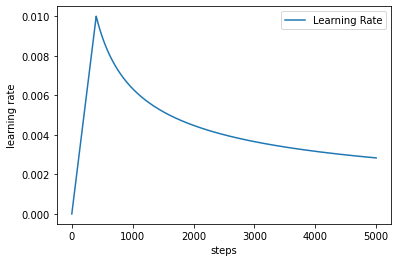

In [141]:
for i in range(5):
    print(f'Learning Rate at step {i} = {trax.lr.warmup_and_rsqrt_decay(400, 0.01)(i)}')
    
x = list(range(5000))
y = [trax.lr.warmup_and_rsqrt_decay(400, 0.01)(i) for i in x]
plt.plot(x,y, label='Learning Rate')
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.legend()
plt.show()

In [142]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

def train_model(model, 
                loss_func,
                lr_schedule=lr_schedule, 
                train_generator=train_generator, 
                val_generator=val_generator, 
                output_dir='model/'):
    
    train_task = training.TrainTask(labeled_data=train_generator,
                                    loss_layer=loss_func(),  # Need to instanstiate the Loss function.
                                    optimizer=trax.optimizers.Adam(0.01),
                                    lr_schedule=lr_schedule,
                                    n_steps_per_checkpoint=100)
    
    eval_task = training.EvalTask(labeled_data=val_generator,
                                  metrics=[loss_func()])   # Need to instanstiate the Loss function.
    
    training_loop = training.Loop(model,  # Instance of the model.
                                  train_task,
                                  eval_tasks=[eval_task],
                                  output_dir=output_dir)
    return training_loop
    

In [143]:
! rm -rf model/
!mkdir model

train_steps = 5000
training_loop = train_model(model=siamese_model(), loss_func=TripletLoss)
training_loop.run(train_steps)

/opt/conda/lib/python3.7/site-packages/jax/_src/lib/xla_bridge.py:520: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "



Step      1: Total number of trainable weights: 9999872
Step      1: Ran 1 train steps in 8.94 secs
Step      1: train TripletLoss |  0.69998401
Step      1: eval  TripletLoss |  0.69997483

Step    100: Ran 99 train steps in 32.98 secs
Step    100: train TripletLoss |  0.68653786
Step    100: eval  TripletLoss |  0.58406764

Step    200: Ran 100 train steps in 31.95 secs
Step    200: train TripletLoss |  0.47402918
Step    200: eval  TripletLoss |  0.42614132

Step    300: Ran 100 train steps in 32.72 secs
Step    300: train TripletLoss |  0.39518183
Step    300: eval  TripletLoss |  0.37863123

Step    400: Ran 100 train steps in 33.04 secs
Step    400: train TripletLoss |  0.30767256
Step    400: eval  TripletLoss |  0.24543893

Step    500: Ran 100 train steps in 33.07 secs
Step    500: train TripletLoss |  0.17747918
Step    500: eval  TripletLoss |  0.13193965

Step    600: Ran 100 train steps in 33.08 secs
Step    600: train TripletLoss |  0.13148575
Step    600: eval  TripletL

## Evalutation

### Compute Accuracy of Model

In [144]:
def get_accuracy(Q1_test, Q2_test, y_test, threshold, model, vocab, data_generator=data_generator, batch_size=64, verbose=False):
    accuracy = 0
    samples_computed = 0
    for i in range(0, len(Q1_test), batch_size):
        # Get pair-wise questions for current batch.
        Q1, Q2 = next(data_generator(Q1_test[i:i + batch_size],
                                     Q2_test[i:i + batch_size],
                                     batch_size=batch_size,
                                     pad=vocab['<PAD>'],
                                     shuffle=False))
        # Get the outputs from the model.
        x1, x2 = model((Q1,Q2))
        
        # Get the true labels identifying if the question pairs are similar or not for the current batch.
        y_test_curr_batch = y_test[i:i + batch_size]
        
        # Compute cosine similarity for all question pairs in the current batch.
        for j in range(batch_size):
            cosine_similarity_score = np.dot(x1[j], x2[j])   # x1[j] and x2[j] are (emb_dim,) dimensional.
            
            res = cosine_similarity_score > threshold     # If score > threshold, assign True(1) otherwise False(0).
            accuracy += (res == y_test[j])   # If result == y_test[j] add to accuracy score.
            samples_computed += 1  # Keep track of samples computed.
        
        if verbose and samples_computed % (10000) == 0: print("Samples computed: ", samples_computed)

    accuracy = (accuracy / samples_computed) * 100
    return accuracy
        

### Load the model

In [145]:
# Load the saved model.
model = siamese_model()
model.init_from_file('./model/model.pkl.gz')


(((array([[-0.10953595,  0.02832606, -0.08289747, ..., -0.03175913,
           -0.13940758, -0.08034933],
          [ 0.4400514 , -0.07744121,  0.01057446, ..., -0.18978208,
           -0.20178787, -0.02322132],
          [ 0.0245336 ,  0.07048524, -0.19453275, ..., -0.23728657,
           -0.03521975,  0.03694341],
          ...,
          [ 0.03032913, -0.06191026,  0.02519845, ...,  0.09698465,
           -0.14500402, -0.12573622],
          [-0.08573526, -0.04375657, -0.13931511, ...,  0.08056236,
           -0.0558885 , -0.0309266 ],
          [-0.139612  , -0.0576432 ,  0.0038606 , ...,  0.05370846,
           -0.05190747,  0.11332086]], dtype=float32),
   (((), ((), ())),
    ((array([[-0.21173927, -0.07550807, -0.386634  , ..., -0.47883067,
               0.08516359, -0.41578478],
             [-0.08929617, -0.91692966, -0.9286664 , ..., -0.0256557 ,
               0.7782548 ,  0.00517336],
             [ 0.21541755, -0.79059625,  0.2854756 , ..., -0.16053723,
               0.

In [146]:
accuracy = get_accuracy(Q1_test, 
                        Q2_test, 
                        y_test, 
                        threshold=0.7,  # This is a hyperparameter.
                        model=model, 
                        vocab=vocab, 
                        data_generator=data_generator, 
                        batch_size=512,
                        verbose=True)
print(f'Accuracy of the Siamese model: {accuracy:.2f}%')

Accuracy of the Siamese model: 51.81%


## Make Predictions

In [157]:
def check_similarity(sent1, sent2, threshold=0.7, vocab=vocab, data_generator=data_generator):
    # Convert sentences to tensor.
    q1 = [[vocab[word] for word in nltk.word_tokenize(sent1)]]
    q2 = [[vocab[word] for word in nltk.word_tokenize(sent2)]]
    
    # Feed the question pair tensors to data generator which adds necessary padding to make them have same length.
    data_gen = data_generator(q1, q2, batch_size=1, pad=vocab['<PAD>'], shuffle=False)
    
    # Extract the appropriate tensors.
    x1, x2 = next(data_gen)
    
    # Get the predictions from the model.
    y1, y2 = model((x1, x2))
    
    # Get cosine similarity score between the outputs.
    cos_sim = np.dot(y1[0], y2[0])  # Transpose not required as y1[0] and y2[0] are 1D Tensors
    
    # Get prediction from the model 0 or 1.
    y_pred = cos_sim > threshold
    
    if y_pred == 1: res = 'similar'
    else: res = 'dissimilar'
    
    print(f'The sentences are {res} with a score of {cos_sim}')

    

In [160]:
check_similarity("When will I see you?", "When can I see you again?")
check_similarity("Do they enjoy eating the dessert?", "Do they like hiking in the desert?")
check_similarity("Is it raining?", "Will it rain today?")
check_similarity("How do you feel?", "How are you feeling?")

The sentences are similar with a score of 0.8106107115745544
The sentences are dissimilar with a score of 0.039453037083148956
The sentences are dissimilar with a score of 0.16361171007156372
The sentences are similar with a score of 0.7828108072280884
